In [9]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import matplotlib


### Extract, Explore, Clean

In [ ]:
# Extract tables from database for initial explore/clean
db_path = '/Users/allisonsteele/Downloads/challenge.db'

conn = None;
try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Extract Access Table
    sql = '''SELECT * FROM access'''
    access= pd.read_sql(sql, conn, index_col='index')
    access_df = pd.DataFrame(access)

    # Extract five_hundred_cities Table
    sql = '''SELECT * FROM five_hundred_cities'''
    five_hundred_cities= pd.read_sql(sql, conn, index_col='index')
    five_hundred_cities_df = pd.DataFrame(five_hundred_cities)

    # Extract variable Table
    sql = '''SELECT * FROM variable_list'''
    variable_list = pd.read_sql(sql, conn, index_col='index')
    variable_list_df = pd.DataFrame(variable_list)

    # show dataframes
    display(access_df.head())
    display(five_hundred_cities_df.head())
    display(variable_list_df.head())


except Error as e: 
  print(e)


# close database connection
finally:
    if conn:
        conn.close()
        print("The SQLite connection is closed")

In [ ]:
# Access Table
access_df.shape # (3143, 44)
# Show columns with missing data 
display(access_df.isnull().sum()[access_df.isnull().sum() > 0].sort_values(ascending=False))
# drop rows with missing data
access_df.dropna(inplace=True)
access_df.shape  # 40 rows dropped

# # Five_hundred_cities Table
five_hundred_cities_df.shape #(27210, 63)
# Show columns with missing data 
display(five_hundred_cities_df.isnull().sum()[five_hundred_cities_df.isnull().sum() > 0])

# update five_hundred_city df to only potential include columns of interest: 
five_hundred_cities_clean = five_hundred_cities_df[['PlaceName', 'StateAbbr', 'PlaceFIPS', 'TractFIPS', 'Population2010', 'BPHIGH_CrudePrev', 'CANCER_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev', 'OBESITY_CrudePrev']]
display(five_hundred_cities_clean.head())

### Prep FIPS codes for join compatibility 
Prep dataframes for joins. 
In the Access database, the FIPS code is 5 characater standard code (state(2)+county(3)), but in the 500 cities the FIPS code are Place and Census tract, so this section explores how I can create a common key for the joins in the analysis.

In [ ]:
pd.options.display.max_rows = 20

# access_df: lenfth of value the FIPS column
display(access_df['FIPS'].astype(str).str.len().value_counts()) 

# Check rows that aren't five 5 characters long
display(access_df[access_df['FIPS'].astype(str).str.len() != 5])  #  no leading 0 for the state fips under 10 

# add a leading 0 to any FIPS that is less than 5 characters long in the access_df
access_df['FIPS'] = access_df['FIPS'].apply(lambda x: '{0:0>5}'.format(x))
display(access_df['FIPS'])

# five_hundred_cities_df: length of the integer stored in the TractFIPS column 
display(five_hundred_cities_df['TractFIPS'].astype(str).str.len().value_counts())

# Check rows that aren't 11 characters long
display(five_hundred_cities_df[five_hundred_cities_df['TractFIPS'].astype(str).str.len() != 11])

# add a leading 0 to any TractFIPS that is less than 11 characters long in the five_hundred_cities_df
five_hundred_cities_df['TractFIPS'] = five_hundred_cities_df['TractFIPS'].apply(lambda x: '{0:0>11}'.format(x))

#check work 
display(five_hundred_cities_df['TractFIPS'])
display(five_hundred_cities_df.head())

# Now that all the FIPS are the same length, create a new column in the five_hundred_cities_df named FIPS that is the first 5 characters of the TractFIPS column, 
# and position it in the dataframe before the PlaceFIPS column. Based on external research that TractFIPS = StateFIPS (2) + CountyFIPS (3) + TractFIPS (6)
five_hundred_cities_df.insert(2, 'FIPS', five_hundred_cities_df['TractFIPS'].str[:5])

#check work
display(five_hundred_cities_df.head())


### Updated DB for SQL Queries

I would have considered doing the analysis in python, but am going to recomit to a database to demonstrate some SQL queries. 

In [ ]:
# Create an updated database with the cleaned dataframes: access_df, five_hundred_cities_df, variable_list_df

conn = None
try:
    # create a new database
    conn = sqlite3.connect('cleaned_challenge_new.db')
    # create a cursor
    cur = conn.cursor()

    # fill the database with the cleaned dataframes
    access_df.to_sql('access_clean', conn, if_exists='replace', index=False)
    five_hundred_cities_df.to_sql('five_hundred_cities_clean', conn, if_exists='replace', index=False)
    variable_list_df.to_sql('variable_list', conn, if_exists='replace', index=False)

except Error as e: 
  print(e)

# quick test 
query = '''SELECT *
FROM access_clean LIMIT 5'''
test = pd.read_sql_query(query, conn)
display(test)

query2 = '''SELECT * FROM five_hundred_cities_clean LIMIT 5'''
test2 = pd.read_sql_query(query2, conn)
display(test2)

# join the access_df and the five_hundred_cities_df on the FIPS column 
county_summary_fivehund = '''
CREATE VIEW county_view_five AS
SELECT FIPS,
      SUM(POPULATION2010) as Tot_Pop_2010, 
      AVG(BPHIGH_CrudePrev) as Avg_BPHIGH_prev, 
      AVG(CANCER_CrudePrev) as Avg_CANCER_prev, 
      AVG(DIABETES_CrudePrev) as Avg_DIABETES_prev, 
      AVG(HIGHCHOL_CrudePrev) as Avg_HIGHCHOL_prev,
      AVG(OBESITY_CrudePrev) as Avg_OBESITY_prev
FROM five_hundred_cities_clean
GROUP BY FIPS'''

query3 = '''SELECT * FROM county_view_five LIMIT 5'''
test3 = pd.read_sql_query(query3, conn)
display(test3)

### 1: Location
Figure out which counties are most impacted by food insecurity currently and have the highest rates of chronic conditions

In [14]:

# find the top fifty counties with the highest number of low income seniors who are limited in their access to stores, only include counties
# where the trend of people having lower access to stores is increasing from 2010 to 2015.

sql_location = '''
SELECT FIPS, 
    State, 
    County, 
    LACCESS_SENIORS15, 
    PCH_LACCESS_POP_10_15
FROM access_clean
Where PCH_LACCESS_POP_10_15 > 0 and LACCESS_LOWI15 > 5000
ORDER BY LACCESS_LOWI15  DESC
LIMIT 50
'''

# Among the top 50 counties with the highest number of low income sneior who are limited in their access to stores, which have the highest prevalence of obesity, 
# high cholesterol, and diabetes. 

sql_location2 = '''
SELECT a.FIPS, 
    State, 
    County, 
    DIABETES_CrudePrev,
    HIGHCHOL_CrudePrev,
    OBESITY_CrudePrev,
    DIABETES_CrudePrev + HIGHCHOL_CrudePrev + OBESITY_CrudePrev as Burden_Proxy
FROM access_clean a JOIN five_hundred_cities_clean c ON a.FIPS = c.FIPS
ORDER BY Burden_Proxy DESC
LIMIT 50
'''


# For the final pilot program launch, where do these two cohorts intersect? Looking to launch in the counties with the greatet need and the greatest burden of chronic disease
# in order to optimize the impact of the program.

sql_location3 = '''
SELECT a.FIPS,
    a.State,
    a.County,
    sum(a.LACCESS_SENIORS15) as Senior_Low_Store_Access,
    sum(b.Burden_Proxy) as Burden_Proxy
FROM (''' + sql_location + ''') a JOIN (''' + sql_location2 + ''') b ON a.FIPS = b.FIPS
GROUP BY a.FIPS
'''

sql_location3_tot ='''
SELECT sum(Senior_Low_Store_Access) as tot_Store_Access
FROM (''' + sql_location3 + ''')
'''

sql_location3_tot_df = pd.read_sql_query(sql_location3_tot, conn)
display(sql_location3_tot_df)

sql_location_df = pd.read_sql_query(sql_location, conn)
display(sql_location_df)

sql_location2_df = pd.read_sql_query(sql_location2, conn)
display(sql_location2_df)

sql_location3_df = pd.read_sql_query(sql_location3, conn)
display(sql_location3_df)

final_fips = sql_location3_df['FIPS'].tolist() # 7 Counties 




,tot_Store_Access
0,415081.782362


,FIPS,State,County,LACCESS_SENIORS15,PCH_LACCESS_POP_10_15
0,04013,AZ,Maricopa,86014.561483,3.846261
1,06037,CA,Los Angeles,81045.209700,1.494213
2,06065,CA,Riverside,57464.459770,0.891339
3,47157,TN,Shelby,25966.765542,7.539677
4,12105,FL,Polk,37116.505055,4.047739
...,...,...,...,...,...
45,42049,PA,Erie,10806.511685,1.701662
46,39093,OH,Lorain,11917.072123,5.179071
47,45019,SC,Charleston,7810.807281,5.732911
48,26077,MI,Kalamazoo,7593.815193,3.004567


,FIPS,State,County,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev,Burden_Proxy
0,36081,NY,Queens,39.5,55.4,41.0,135.9
1,39035,OH,Cuyahoga,36.1,44.8,53.7,134.6
2,01097,AL,Mobile,33.1,46.2,54.2,133.5
3,39113,OH,Montgomery,34.9,46.4,49.9,131.2
4,47065,TN,Hamilton,31.4,47.8,51.6,130.8
...,...,...,...,...,...,...,...
45,42049,PA,Erie,24.3,47.9,46.9,119.1
46,39095,OH,Lucas,25.0,37.0,57.0,119.0
47,22017,LA,Caddo,26.2,41.9,50.7,118.8
48,40109,OK,Oklahoma,24.4,44.3,50.1,118.8


,FIPS,State,County,Senior_Low_Store_Access,Burden_Proxy
0,01101,AL,Montgomery,20530.592895,370.0
1,18089,IN,Lake,94566.034606,607.4
2,39035,OH,Cuyahoga,218770.596097,635.5
3,39061,OH,Hamilton,32824.605356,124.4
4,39151,OH,Stark,17205.424178,126.5
5,42049,PA,Erie,10806.511685,119.1
6,47065,TN,Hamilton,20378.017545,130.8


### Visualization 1: Map Pilot Program Launch



In [15]:
import plotly.express as px

fig = px.choropleth(sql_location3_df,
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Senior_Low_Store_Access',
                    color_continuous_scale="Viridis_r",
                    hover_name='County', 
                    hover_data=['State', 'Senior_Low_Store_Access', 'Burden_Proxy'],
                    )

fig.update_layout(
      title_text = 'Pilot Program Locations',
      title_font_family="Lato",
      title_font_size = 16,
      title_font_color="black", 
      title_x=0.45, 
)

fig.show()

### 2: Program Reach and Impact

Simplyfing Assumption: The program will target Medicare Advantage members, the majority of which are 65+. The analysis will assume that the designation of "Seniors" in the dataset indicate they are 65+. This analysis also assumes this specific Medicare Advantage plan has 50% of the market share.  

In [16]:
# Find number of Senior with low access to stores in pilot counties who likely have one of the 3 qualifying
# conditions: diabetes, high cholesterol, or obesity. Becuase these are frequently co-morbid conditions, it is 
# likely that this is an under estimation as i am only using the largest prevalance between the three diseases as the proxy for reach. 

sql_location_reach = '''
SELECT a.FIPS,
    a.State,
    a.County,
    sum(a.LACCESS_SENIORS15) as Senior_Low_Store_Access,
    avg(b.DIABETES_CrudePrev) as avg_DIABETES_CrudePrev,
    avg(b.HIGHCHOL_CrudePrev) as avg_HIGHCHOL_CrudePrev,
    avg(b.OBESITY_CrudePrev) as avg_OBESITY_CrudePrev
FROM (''' + sql_location + ''') a JOIN (''' + sql_location2 + ''') b ON a.FIPS = b.FIPS
GROUP BY a.FIPS
'''

sql_reach = '''
SELECT FIPS,
    State,
    County,
    Senior_Low_Store_Access,
    avg_DIABETES_CrudePrev,
    avg_HIGHCHOL_CrudePrev,
    avg_OBESITY_CrudePrev,
    CASE 
        WHEN avg_DIABETES_CrudePrev >= avg_HIGHCHOL_CrudePrev AND avg_DIABETES_CrudePrev >= avg_OBESITY_CrudePrev THEN avg_DIABETES_CrudePrev
        WHEN avg_HIGHCHOL_CrudePrev >= avg_DIABETES_CrudePrev AND avg_HIGHCHOL_CrudePrev >= avg_OBESITY_CrudePrev THEN avg_HIGHCHOL_CrudePrev 
        ELSE avg_OBESITY_CrudePrev 
    END / 100 * Senior_Low_Store_Access AS Reach_Est 
FROM (''' + sql_location_reach + '''
)
'''

sql_reach_tot = '''
SELECT sum(Reach_Est) as Reach_Est_Total
FROM (''' + sql_reach + ''')
'''


sql_location_reach_df = pd.read_sql_query(sql_location_reach, conn)
display(sql_location_reach_df)

sql_reach_df = pd.read_sql_query(sql_reach, conn)
display(sql_reach_df) # 162,654

sql_reach_tot_df = pd.read_sql_query(sql_reach_tot, conn) # 6,198,903
display(sql_reach_tot_df) 


,FIPS,State,County,Senior_Low_Store_Access,avg_DIABETES_CrudePrev,avg_HIGHCHOL_CrudePrev,avg_OBESITY_CrudePrev
0,01101,AL,Montgomery,20530.592895,28.20,42.466667,52.666667
1,18089,IN,Lake,94566.034606,28.20,40.420000,52.860000
2,39035,OH,Cuyahoga,218770.596097,32.12,41.680000,53.300000
3,39061,OH,Hamilton,32824.605356,30.00,40.400000,54.000000
4,39151,OH,Stark,17205.424178,27.80,45.900000,52.800000
5,42049,PA,Erie,10806.511685,24.30,47.900000,46.900000
6,47065,TN,Hamilton,20378.017545,31.40,47.800000,51.600000


,FIPS,State,County,Senior_Low_Store_Access,avg_DIABETES_CrudePrev,avg_HIGHCHOL_CrudePrev,avg_OBESITY_CrudePrev,Reach_Est
0,01101,AL,Montgomery,20530.592895,28.20,42.466667,52.666667,10812.778925
1,18089,IN,Lake,94566.034606,28.20,40.420000,52.860000,49987.605893
2,39035,OH,Cuyahoga,218770.596097,32.12,41.680000,53.300000,116604.727720
3,39061,OH,Hamilton,32824.605356,30.00,40.400000,54.000000,17725.286892
4,39151,OH,Stark,17205.424178,27.80,45.900000,52.800000,9084.463966
5,42049,PA,Erie,10806.511685,24.30,47.900000,46.900000,5176.319097
6,47065,TN,Hamilton,20378.017545,31.40,47.800000,51.600000,10515.057053


,Reach_Est_Total
0,219906.239546


### 3: Subgroup analysis 

Simplyfying assumption: The % of low access to store by race does not change with age. Likely not true, but I don't have age-adjusted data. 

In [17]:

sql_subgroups = '''
SELECT  
    avg(PCT_LACCESS_WHITE15) as White, 
    avg(PCT_LACCESS_BLACK15) as Black, 
    avg(PCT_LACCESS_HISP15) as Hispanic, 
    avg(PCT_LACCESS_NHASIAN15) as Asian,
    avg(PCT_LACCESS_LOWI15) as LowIncome,
    avg(DIABETES_CrudePrev) as Diabetes,
    avg(HIGHCHOL_CrudePrev) as HighCholesterol,
    avg(OBESITY_CrudePrev) as Obesity
FROM access_clean a JOIN five_hundred_cities_clean b ON a.FIPS = b.FIPS 
WHERE a.FIPS IN (''' + str(final_fips)[1:-1] + ''')
'''

sql_subgroups_df = pd.read_sql_query(sql_subgroups, conn)
display(sql_subgroups_df)

,White,Black,Hispanic,Asian,LowIncome,Diabetes,HighCholesterol,Obesity
0,18.695873,6.559069,0.970724,0.49444,8.30495,15.578598,33.599621,39.524053


### Visualization 2: Sub Group Bar Plot

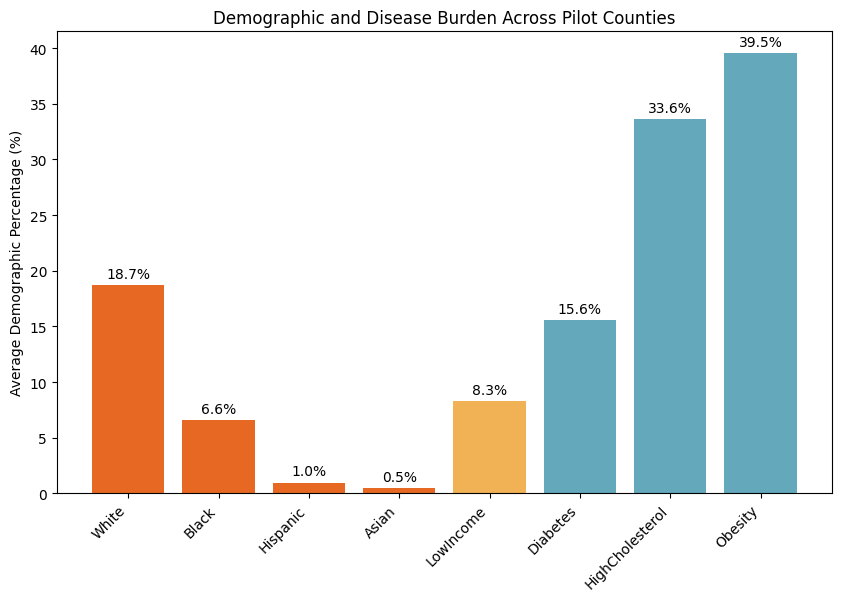

<Figure size 640x480 with 0 Axes>

In [18]:
# Create a list of subgroups/colors
subgroups = ['White', 'Black', 'Hispanic', 'Asian', 'LowIncome', 'Diabetes', 'HighCholesterol', 'Obesity']
colors = ['#E66822', '#E66822', '#E66822', '#E66822', '#F1B256', '#63A8BB', '#63A8BB', '#63A8BB']

# set font
matplotlib.rcParams['font.family'] = 'Sans-Serif'

# Create a bar plot  
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(subgroups, sql_subgroups_df.values.tolist()[0], color=colors)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3), 
                textcoords='offset points', 
                ha='center', 
                va='bottom')

# Set the x-axis and y-axis labels
ax.set_ylabel('Average Demographic Percentage (%)')
ax.set_title('Demographic and Disease Burden Across Pilot Counties')

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()
plt.savefig('my_plot.jpg')
